1. What assets? What dates, etc.

2. Description of strategies, both mathematical and intuitive

3. Select graphs from the output to include and explain it. What is the main message of the graphs?

4. Make heatmaps by varying the two moving average parameters. Highlight CAGR in one and Daily Sharpe in the other heatmap. Comment on the heatmaps.

5. Compare to the benchmark of buy and hold TSLA. Comment on SMA Crossover vs buy and hold strategies.

6. Should be under 2 pages single spaced text (graph not included). One page should be plenty.

The Strategy:

Build a SMA crossover strategy to TSLA from the period 1/1/20 to 6/1/21. Vary the short SMA from 20 - 40 in steps of 1. Vary the long SMA from 150 - 250 in steps of 5. Build heatmaps as explained in step 4.



In [1]:
import pandas as pd
import bt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import talib

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def buy_and_hold(ticker, name, start='2020-1-1', end='2021-6-1'):
    # Get the data
    price_data = bt.get(ticker, start=start, end=end)
    # Define the benchmark strategy
    bt_strategy = bt.Strategy(name, 
                              [bt.algos.RunOnce(),
                               bt.algos.SelectAll(),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
    # Return the backtest
    return bt.Backtest(bt_strategy, price_data)


In [4]:
def signal_strategy(ticker, period, name, start='2020-1-1', end='2021-6-1'):
    # Get the data and calculate SMA
    price_data = bt.get(ticker, start=start, end=end)
    sma = price_data.rolling(period).mean()
    # Define the signal-based trategy
    bt_strategy = bt.Strategy(name,
                              [bt.algos.SelectWhere(price_data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
    # Return the backtest
    return bt.Backtest(bt_strategy, price_data)



In [5]:
def moving_average_cross(tickers, start_date, end_date, short_period, long_period, tgt_weight, graphs=False):
    # Price Data for the tickers in prescribed time period
    data = bt.get(tickers, start=start_date, end=end_date)
    # SMA for short and long term
    sma_short = data.rolling(short_period).mean()
    sma_long = data.rolling(long_period).mean()
    # Merge Long and ShortSMA
    if(graphs):
        plt.figure(figsize=(14,14))
        plot = bt.merge(data, sma_short, sma_long).plot(figsize=(15, 5), title='Data - Short term MA - Long term MA')
        plt.show()
    # Handle Target Weights
    target_weights = sma_long.copy()
    target_weights[sma_short > sma_long] =  tgt_weight
    target_weights[sma_short <= sma_long] = (-1 * tgt_weight)
    # Now set up the MA_cross strategy for our moving average cross strategy
    MA_cross = bt.Strategy('MA_cross', [bt.algos.WeighTarget(target_weights),
                                    bt.algos.Rebalance()])
    test_MA = bt.Backtest(MA_cross, data)
    # Run Strategy
    bt_result = bt.run(test_MA)
    # Run Bt Result
    return bt_result

In [6]:
def bt_stats_to_dict(bt_results):
    df = bt_results.stats
    column = df.columns[0]
    return df.to_dict()[column]

In [7]:
def core_params(bt_results):
    dict = bt_stats_to_dict(bt_results)
    return round(dict['cagr']*100,2), round(dict['daily_sharpe']*100,2), round(dict['daily_sortino']*100,2)


In [8]:
# Assets
ticker = 'TSLA'
start='2020-1-1'
end='2021-6-1'

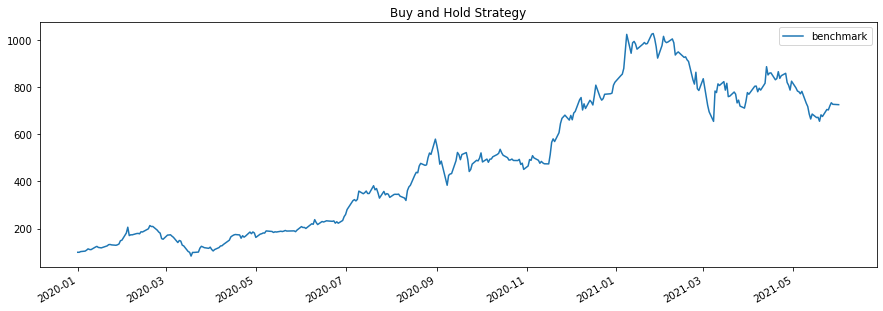

In [9]:
# Create benchmark strategy backtest
benchmark = buy_and_hold(ticker, name='benchmark')

# Run all backtests and plot the resutls
bt_result = bt.run(benchmark)

# Plot bt_result
bt_result.plot(title='Buy and Hold Strategy')
plt.show()

In [10]:
def backtest_stats(bt_res, strategy_name):
    
    print('------------ %s ------------'% strategy_name)
    
    # Obtain all backtest stats
    resInfo = bt_res.stats

    # Get daily, monthly, and yearly returns
    print('Daily return: %.4f'% resInfo.loc['daily_mean'].iloc[0])
    print('Monthly return: %.4f'% resInfo.loc['monthly_mean'].iloc[0])
    print('Yearly return: %.4f'% resInfo.loc['yearly_mean'].iloc[0])
    
    # Get the compound annual growth rate
    print('Daily Sharpe Ratio: %.2f'% resInfo.loc['daily_sharpe'].iloc[0])
    print('Compound annual growth rate: %.2f%%'% round(resInfo.loc['cagr'].iloc[0]*100, 2))

    print('----------------------------------------')



In [11]:
backtest_stats(bt_res=bt_result, strategy_name='Buy and Hold')

------------ Buy and Hold ------------
Daily return: 1.7507
Monthly return: 1.4881
Yearly return: -0.1159
Daily Sharpe Ratio: 2.10
Compound annual growth rate: 305.32%
----------------------------------------


### Varying Time Periods for Simple Moving Averages

In [12]:
short_sma_lst = []
long_sma_lst = []
cagr_lst = []
sharpe_lst = []
sortino_lst = []
# Loop through sma short period and sma long period
for sma_long_index in range(150, 250, 5):
    for sma_short_index in range(20, 40, 1):
        sma_short = signal_strategy(ticker, period=sma_short_index, name='SMAShort')
        sma_long = signal_strategy(ticker, period=sma_long_index, name='SMALong')
        
        bt_results = moving_average_cross(ticker, start, end, sma_short_index, sma_long_index, 0.2, False)
        
        cagr, sharpe, sortino = core_params(bt_results)
        
        # Add it to list
        short_sma_lst.append(sma_short_index)
        long_sma_lst.append(sma_long_index)
        cagr_lst.append(cagr)
        sharpe_lst.append(sharpe)
        sortino_lst.append(sortino)
    
df = pd.DataFrame({
    "sma_short": short_sma_lst,
    "sma_long": long_sma_lst,
    "cagr": cagr_lst,
    "sharpe": sharpe_lst,
    "sortino": sortino_lst
})
df


,sma_short,sma_long,cagr,sharpe,sortino
0,20,150,11.79,106.34,180.46
1,21,150,11.79,106.34,180.46
2,22,150,11.47,103.74,176.11
3,23,150,11.47,103.74,176.11
4,24,150,11.47,103.74,176.11
...,...,...,...,...,...
395,35,245,-0.55,-4.28,-6.98
396,36,245,-0.55,-4.28,-6.98
397,37,245,-0.55,-4.28,-6.98
398,38,245,-0.55,-4.28,-6.98


## MA Cross Strategy

Our Success Parameters 

<b>SMA_SHORT - 31 or 32<br/>
SMA_LONG  - 150<br/>Our Max CAGR - 14.14%</b>

In [13]:
df.sort_values(by='cagr', ascending=False)

,sma_short,sma_long,cagr,sharpe,sortino
11,31,150,14.14,125.33,213.58
12,32,150,14.14,125.33,213.58
13,33,150,13.85,123.03,209.74
19,39,150,13.79,122.49,208.84
18,38,150,13.79,122.49,208.84
...,...,...,...,...,...
383,23,245,-0.55,-4.28,-6.98
382,22,245,-0.55,-4.28,-6.98
381,21,245,-0.55,-4.28,-6.98
380,20,245,-0.55,-4.28,-6.98


### Plot Heatmaps

In [14]:
pivotted= df.pivot('sma_long','sma_short','cagr')
pivotted

sma_short,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
sma_long,,,,,,,,,,,,,,,,,,,,
150,11.79,11.79,11.47,11.47,11.47,12.86,12.86,12.77,12.77,13.53,13.53,14.14,14.14,13.85,13.79,13.79,13.79,13.79,13.79,13.79
155,10.95,10.63,10.63,12.02,11.93,11.93,12.69,12.69,13.29,13.29,13.01,13.01,12.94,12.94,12.94,12.94,12.94,12.94,12.94,12.94
160,7.62,8.97,8.88,8.88,9.62,9.62,10.21,9.93,9.93,9.86,9.86,9.86,9.86,9.86,9.86,9.86,9.86,9.86,9.86,9.86
165,6.86,6.77,6.77,7.49,8.07,7.80,7.80,7.73,7.73,7.73,7.73,7.73,7.73,7.73,7.73,7.73,7.73,7.73,7.73,7.73
170,6.07,6.79,7.36,7.36,7.09,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03,7.03
175,9.16,9.75,9.47,9.47,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41,9.41
180,7.33,7.33,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27
185,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49,8.49
190,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27,6.27


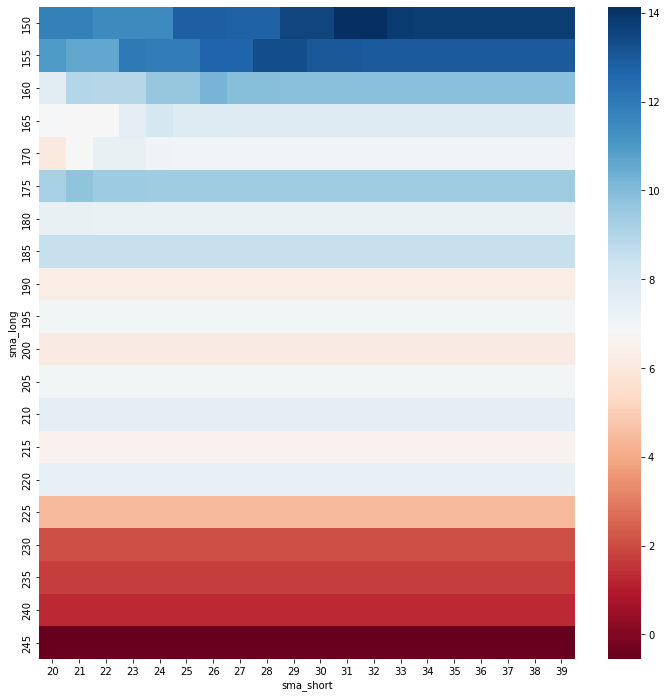

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(pivotted,cmap='RdBu')
plt.show()

### Sharpe Ratio Heatmap

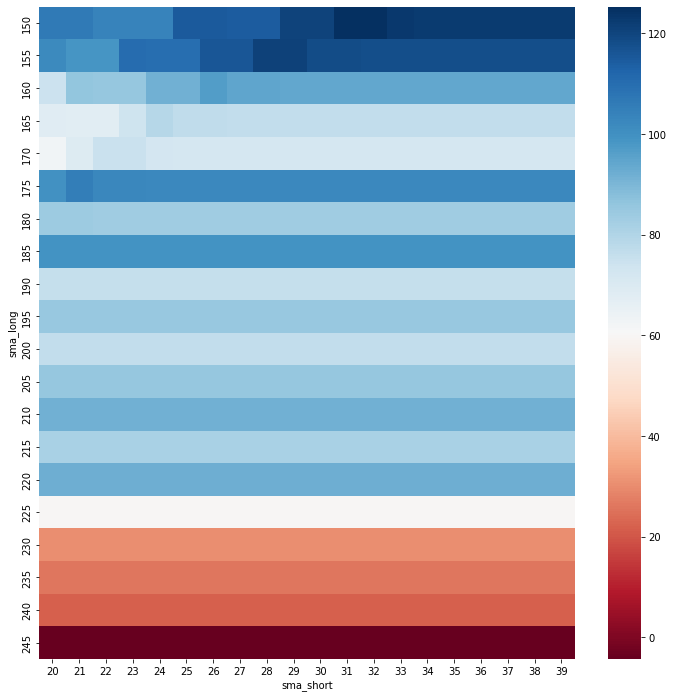

In [16]:
pivot_tbl_sharpe= df.pivot('sma_long','sma_short','sharpe')
plt.figure(figsize=(12,12))
sns.heatmap(pivot_tbl_sharpe,cmap='RdBu')
plt.show()

## Plots for Shorter Time Frames

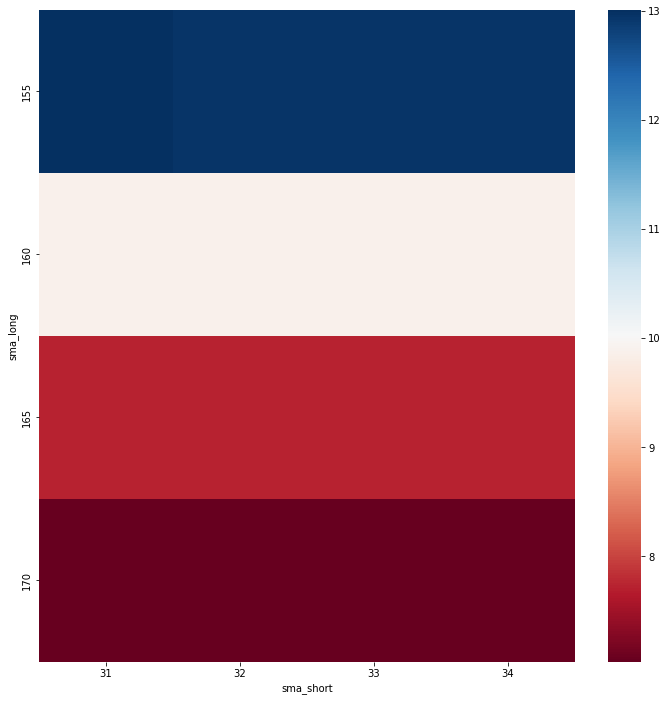

In [21]:
pivot_tbl_cagr= df[(df['sma_short'] > 30) & (df['sma_short'] < 35) & (df['sma_long'] > 150) & (df['sma_long'] < 175)].pivot('sma_long','sma_short','cagr')
plt.figure(figsize=(12,12))
sns.heatmap(pivot_tbl_cagr,cmap='RdBu')
plt.show()

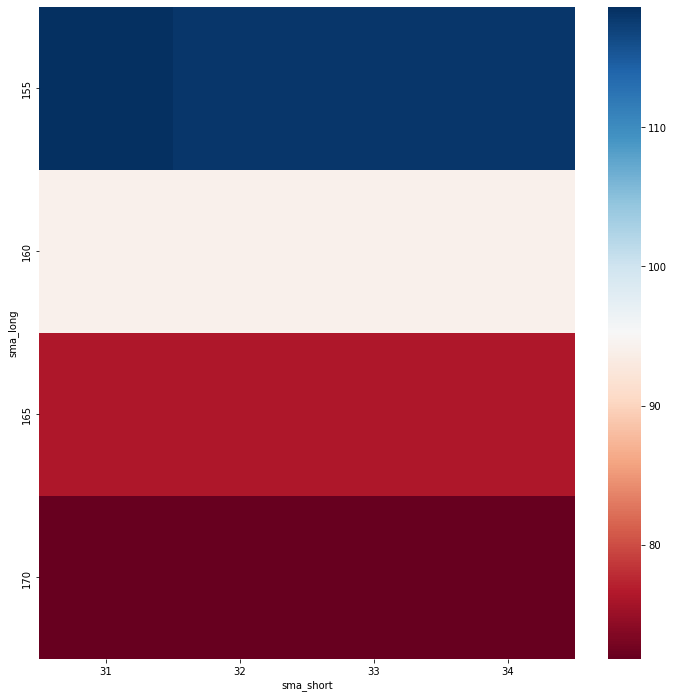

In [20]:
pivot_tbl_sharpe= df[(df['sma_short'] > 30) & (df['sma_short'] < 35) & (df['sma_long'] > 150) & (df['sma_long'] < 175)].pivot('sma_long','sma_short','sharpe')
plt.figure(figsize=(12,12))
sns.heatmap(pivot_tbl_sharpe,cmap='RdBu')
plt.show()